In [2]:
%pip install sentence-transformers


  Using cached sentence_transformers-2.7.0-py3-none-any.whl.metadata (11 kB)
Using cached sentence_transformers-2.7.0-py3-none-any.whl (171 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertConfig
from sentence_transformers import SentenceTransformer
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm


In [13]:
embedding_model = SentenceTransformer('distilbert-base-nli-mean-tokens')



In [93]:
def get_data_lists(data):
    questions = []
    choices = []
    labels = []
    for example in data:
        # print(example.keys())
        questions.append(example['question'])
        choices.append(example['choice_list'])
        labels.append(example['label'])
    return questions, choices, labels

class Brain_Teaser(Dataset):
  def __init__(self, tokenizer, questions, choices, labels, max_len=512):
    self.questions = questions
    self.choices = choices
    self.labels = labels

    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self.question_options_encoded = []

    self.build_questions()
  
  def build_questions(self):
    maxi = 0
    for id in range(len(self.questions)):
      question_options = "Question : " + self.questions[id] + ' ' + "Option: 0" + ' ' + self.choices[id][0] + ' Option: 1 ' + self.choices[id][1] + ' Option: 2 ' + self.choices[id][2] + ' Option: 3 ' + self.choices[id][3]
      self.question_options_encoded.append(self.tokenizer.encode(question_options, convert_to_tensor = True))
    
  def __len__(self):
    return len(self.question_options_encoded)
  
  def __getitem__(self, id):
    return self.question_options_encoded[id],  self.labels[id]
    

class Brain_Teaser_2(Dataset):
  def __init__(self, tokenizer, questions, choices, labels, max_len=512):
    self.questions = questions
    self.choices = choices
    self.labels = labels

    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self.question_options_encoded = []

    self.build_questions()
  
  def build_questions(self):
    maxi = 0
    for id in range(len(self.questions)):
      qo = []
      for option_id in range(4):
        question_options = "Question : " + self.questions[id] + ' ' + "Option: " + str(option_id) + ' ' + self.choices[id][option_id] 
        qo.append(self.tokenizer.encode(question_options, convert_to_tensor = True))
      self.question_options_encoded.append(qo)
    
  def __len__(self):
    return len(self.question_options_encoded)
  
  def __getitem__(self, id):
    return torch.stack(self.question_options_encoded[id]),  self.labels[id]  

In [138]:
train_data = np.load("data/SP-train.npy", allow_pickle=True)
test_data = np.load("data/SP_eval_data_for_practice.npy", allow_pickle = True)

train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)
train_questions, train_choices, train_labels = get_data_lists(train_data)
val_questions, val_choices, val_labels = get_data_lists(val_data)

In [139]:
train_dataset = Brain_Teaser(embedding_model, train_questions, train_choices, train_labels)
val_dataset = Brain_Teaser(embedding_model, val_questions, val_choices, val_labels)



In [140]:
train_dataset_2 = Brain_Teaser_2(embedding_model, train_questions, train_choices, train_labels)
val_dataset_2 = Brain_Teaser_2(embedding_model, val_questions, val_choices, val_labels)

In [141]:
class SentenceModel(nn.Module):
    def __init__(self):
        super(SentenceModel, self).__init__()
        self.fc_1 = nn.Linear(768, 256)
        self.bn_1 = nn.BatchNorm1d(256)  
        self.dropout_1 = nn.Dropout(0.2)  
        self.fc_2 = nn.Linear(256, 32)
        self.bn_2 = nn.BatchNorm1d(32)  
        self.dropout_2 = nn.Dropout(0.3)  
        self.fc_3 = nn.Linear(32, 4)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.bn_1(out)  
        out = nn.functional.relu(out)  
        out = self.dropout_1(out)  
        out = self.fc_2(out)
        out = self.bn_2(out)  
        out = nn.functional.relu(out)  
        out = self.dropout_2(out) 
        out = self.fc_3(out)
        return out

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru_1 = nn.GRU(768, 256, num_layers=1,batch_first=True)
        self.gru_2 = nn.GRU(256, 64, num_layers=1,batch_first=True)
        self.fc_1 = nn.Linear(64, 16)
        self.fc_2 = nn.Linear(16, 4)

    def forward(self, x):
        out, _ = self.gru_1(x)  
        out, _ = self.gru_2(out)              
        out = self.fc_1(out[:, -1, :])
        out = self.fc_2(out)
        return out
    
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn_1 = nn.RNN(768, 256, num_layers=1,batch_first=True)
        self.rnn_2 = nn.RNN(256, 64, num_layers=1,batch_first=True)
        self.fc_1 = nn.Linear(64, 16)
        self.fc_2 = nn.Linear(16, 4)

    def forward(self, x):
        out, _ = self.rnn_1(x)  
        out, _ = self.rnn_2(out)              
        out = self.fc_1(out[:, -1, :])
        out = self.fc_2(out)
        return out

In [142]:
def train(train_dataset, val_dataset, model, epochs=60, learning_rate=5e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        t_correct = 0
        t_total = 0
        for inputs, targets in tqdm.tqdm(train_dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            _, predicted = torch.max(outputs, 1)
            t_total += targets.size(0)
            t_correct += (predicted == targets).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        train_loss = running_loss / len(train_dataloader)
        val_loss = val_loss / len(val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
                f"Train Accuracy: {(100 * t_correct / t_total):.2f}% , "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {(100 * correct / total):.2f}%")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example usage:



100%|██████████| 54/54 [00:00<00:00, 326.84it/s]


Epoch [1/60], Train Loss: 1.3537, Train Accuracy: 26.98% , Val Loss: 1.2856, Val Accuracy: 36.36%


100%|██████████| 54/54 [00:00<00:00, 701.52it/s]


Epoch [2/60], Train Loss: 1.2020, Train Accuracy: 39.07% , Val Loss: 1.2467, Val Accuracy: 32.47%


100%|██████████| 54/54 [00:00<00:00, 705.23it/s]


Epoch [3/60], Train Loss: 1.1485, Train Accuracy: 40.93% , Val Loss: 1.1811, Val Accuracy: 40.26%


100%|██████████| 54/54 [00:00<00:00, 695.40it/s]


Epoch [4/60], Train Loss: 1.1119, Train Accuracy: 47.21% , Val Loss: 1.1587, Val Accuracy: 40.26%


100%|██████████| 54/54 [00:00<00:00, 697.11it/s]


Epoch [5/60], Train Loss: 1.0735, Train Accuracy: 48.60% , Val Loss: 1.0892, Val Accuracy: 48.05%


100%|██████████| 54/54 [00:00<00:00, 751.49it/s]


Epoch [6/60], Train Loss: 1.0510, Train Accuracy: 50.23% , Val Loss: 1.1226, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 749.96it/s]


Epoch [7/60], Train Loss: 1.0372, Train Accuracy: 51.40% , Val Loss: 1.1221, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 681.46it/s]


Epoch [8/60], Train Loss: 0.9370, Train Accuracy: 59.77% , Val Loss: 1.1936, Val Accuracy: 40.26%


100%|██████████| 54/54 [00:00<00:00, 748.78it/s]


Epoch [9/60], Train Loss: 0.9934, Train Accuracy: 50.93% , Val Loss: 1.1529, Val Accuracy: 37.66%


100%|██████████| 54/54 [00:00<00:00, 747.84it/s]


Epoch [10/60], Train Loss: 0.9487, Train Accuracy: 59.30% , Val Loss: 1.0853, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 736.70it/s]


Epoch [11/60], Train Loss: 0.9250, Train Accuracy: 58.60% , Val Loss: 1.1279, Val Accuracy: 40.26%


100%|██████████| 54/54 [00:00<00:00, 555.56it/s]


Epoch [12/60], Train Loss: 0.8907, Train Accuracy: 59.53% , Val Loss: 1.1553, Val Accuracy: 45.45%


100%|██████████| 54/54 [00:00<00:00, 254.64it/s]


Epoch [13/60], Train Loss: 0.8469, Train Accuracy: 65.58% , Val Loss: 1.3430, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 533.02it/s]


Epoch [14/60], Train Loss: 0.8842, Train Accuracy: 61.63% , Val Loss: 1.2840, Val Accuracy: 40.26%


100%|██████████| 54/54 [00:00<00:00, 567.86it/s]


Epoch [15/60], Train Loss: 0.8479, Train Accuracy: 62.56% , Val Loss: 1.2559, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 600.77it/s]


Epoch [16/60], Train Loss: 0.8161, Train Accuracy: 62.09% , Val Loss: 1.2847, Val Accuracy: 40.26%


100%|██████████| 54/54 [00:00<00:00, 706.86it/s]


Epoch [17/60], Train Loss: 0.7497, Train Accuracy: 67.44% , Val Loss: 1.2142, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 704.80it/s]


Epoch [18/60], Train Loss: 0.7417, Train Accuracy: 66.98% , Val Loss: 1.3182, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 708.66it/s]


Epoch [19/60], Train Loss: 0.7679, Train Accuracy: 68.60% , Val Loss: 1.3020, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 766.46it/s]


Epoch [20/60], Train Loss: 0.7699, Train Accuracy: 66.28% , Val Loss: 1.3764, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 672.85it/s]


Epoch [21/60], Train Loss: 0.7789, Train Accuracy: 66.74% , Val Loss: 1.3502, Val Accuracy: 37.66%


100%|██████████| 54/54 [00:00<00:00, 691.39it/s]


Epoch [22/60], Train Loss: 0.7254, Train Accuracy: 70.23% , Val Loss: 1.3410, Val Accuracy: 37.66%


100%|██████████| 54/54 [00:00<00:00, 728.24it/s]


Epoch [23/60], Train Loss: 0.7435, Train Accuracy: 68.84% , Val Loss: 1.4079, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 729.59it/s]


Epoch [24/60], Train Loss: 0.6985, Train Accuracy: 67.91% , Val Loss: 1.5890, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 732.63it/s]


Epoch [25/60], Train Loss: 0.7382, Train Accuracy: 70.00% , Val Loss: 1.5513, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 747.01it/s]


Epoch [26/60], Train Loss: 0.6569, Train Accuracy: 70.70% , Val Loss: 1.6169, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 766.77it/s]


Epoch [27/60], Train Loss: 0.6723, Train Accuracy: 70.47% , Val Loss: 1.6231, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 756.06it/s]


Epoch [28/60], Train Loss: 0.6163, Train Accuracy: 76.05% , Val Loss: 1.6154, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 774.69it/s]


Epoch [29/60], Train Loss: 0.6830, Train Accuracy: 70.70% , Val Loss: 1.5375, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 786.13it/s]


Epoch [30/60], Train Loss: 0.6649, Train Accuracy: 73.49% , Val Loss: 1.4666, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 738.50it/s]


Epoch [31/60], Train Loss: 0.7256, Train Accuracy: 69.53% , Val Loss: 1.6391, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 778.02it/s]


Epoch [32/60], Train Loss: 0.6002, Train Accuracy: 73.72% , Val Loss: 1.6647, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 769.85it/s]


Epoch [33/60], Train Loss: 0.5879, Train Accuracy: 76.28% , Val Loss: 1.6317, Val Accuracy: 40.26%


100%|██████████| 54/54 [00:00<00:00, 752.88it/s]


Epoch [34/60], Train Loss: 0.6358, Train Accuracy: 75.35% , Val Loss: 1.5228, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 677.90it/s]


Epoch [35/60], Train Loss: 0.6125, Train Accuracy: 71.86% , Val Loss: 1.6578, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 613.48it/s]


Epoch [36/60], Train Loss: 0.6098, Train Accuracy: 76.05% , Val Loss: 1.6667, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 658.87it/s]


Epoch [37/60], Train Loss: 0.5388, Train Accuracy: 77.44% , Val Loss: 1.6102, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 697.88it/s]


Epoch [38/60], Train Loss: 0.5725, Train Accuracy: 74.19% , Val Loss: 1.8102, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 703.62it/s]


Epoch [39/60], Train Loss: 0.5939, Train Accuracy: 76.28% , Val Loss: 1.8654, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 740.70it/s]


Epoch [40/60], Train Loss: 0.6240, Train Accuracy: 72.33% , Val Loss: 1.7683, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 668.19it/s]


Epoch [41/60], Train Loss: 0.5537, Train Accuracy: 78.14% , Val Loss: 1.6443, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 730.65it/s]


Epoch [42/60], Train Loss: 0.6112, Train Accuracy: 73.49% , Val Loss: 1.8825, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 731.55it/s]


Epoch [43/60], Train Loss: 0.5240, Train Accuracy: 79.77% , Val Loss: 1.8259, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 677.39it/s]


Epoch [44/60], Train Loss: 0.5386, Train Accuracy: 75.81% , Val Loss: 1.9184, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 699.29it/s]


Epoch [45/60], Train Loss: 0.5660, Train Accuracy: 76.51% , Val Loss: 1.7831, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 742.23it/s]


Epoch [46/60], Train Loss: 0.5687, Train Accuracy: 76.28% , Val Loss: 1.8087, Val Accuracy: 40.26%


100%|██████████| 54/54 [00:00<00:00, 700.65it/s]


Epoch [47/60], Train Loss: 0.5437, Train Accuracy: 77.21% , Val Loss: 1.7806, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 721.05it/s]


Epoch [48/60], Train Loss: 0.5905, Train Accuracy: 73.49% , Val Loss: 1.6753, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 729.85it/s]


Epoch [49/60], Train Loss: 0.5594, Train Accuracy: 78.60% , Val Loss: 1.8586, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 722.78it/s]


Epoch [50/60], Train Loss: 0.4767, Train Accuracy: 80.23% , Val Loss: 1.8490, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 729.23it/s]


Epoch [51/60], Train Loss: 0.5387, Train Accuracy: 76.05% , Val Loss: 1.8635, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 633.07it/s]


Epoch [52/60], Train Loss: 0.5442, Train Accuracy: 74.88% , Val Loss: 1.7066, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 723.73it/s]


Epoch [53/60], Train Loss: 0.4664, Train Accuracy: 81.16% , Val Loss: 2.0334, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 706.50it/s]


Epoch [54/60], Train Loss: 0.5526, Train Accuracy: 75.12% , Val Loss: 1.7151, Val Accuracy: 45.45%


100%|██████████| 54/54 [00:00<00:00, 747.12it/s]


Epoch [55/60], Train Loss: 0.5829, Train Accuracy: 77.91% , Val Loss: 1.7975, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 656.82it/s]


Epoch [56/60], Train Loss: 0.4519, Train Accuracy: 81.63% , Val Loss: 2.0407, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 761.73it/s]


Epoch [57/60], Train Loss: 0.4460, Train Accuracy: 81.16% , Val Loss: 2.1554, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 763.43it/s]


Epoch [58/60], Train Loss: 0.5555, Train Accuracy: 76.28% , Val Loss: 2.1418, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 687.68it/s]


Epoch [59/60], Train Loss: 0.5041, Train Accuracy: 78.60% , Val Loss: 2.0617, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 736.93it/s]


Epoch [60/60], Train Loss: 0.4847, Train Accuracy: 79.77% , Val Loss: 2.1508, Val Accuracy: 41.56%


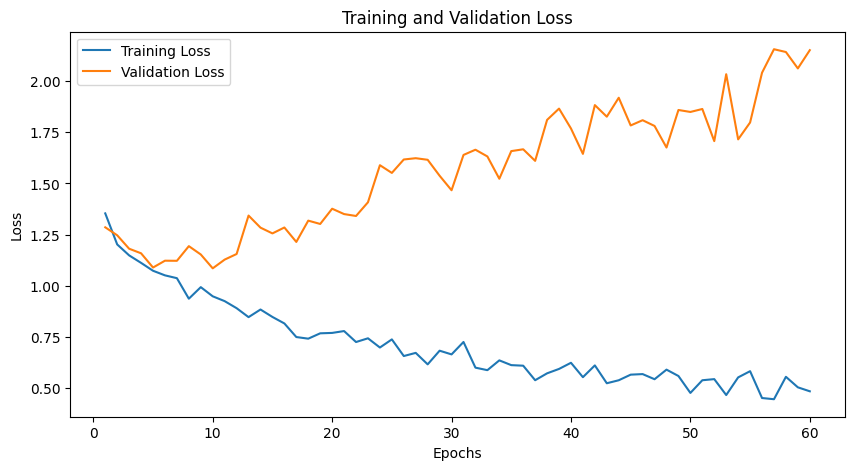

In [143]:
model_sentence_fc = SentenceModel()
train(train_dataset, val_dataset, model_sentence_fc)

100%|██████████| 54/54 [00:00<00:00, 172.37it/s]


Epoch [1/30], Train Loss: 1.2987, Train Accuracy: 30.23% , Val Loss: 1.2866, Val Accuracy: 29.87%


100%|██████████| 54/54 [00:00<00:00, 201.37it/s]


Epoch [2/30], Train Loss: 1.1609, Train Accuracy: 41.86% , Val Loss: 1.2636, Val Accuracy: 37.66%


100%|██████████| 54/54 [00:00<00:00, 196.97it/s]


Epoch [3/30], Train Loss: 1.0994, Train Accuracy: 44.88% , Val Loss: 1.2056, Val Accuracy: 45.45%


100%|██████████| 54/54 [00:00<00:00, 203.65it/s]


Epoch [4/30], Train Loss: 1.0044, Train Accuracy: 49.53% , Val Loss: 1.2543, Val Accuracy: 32.47%


100%|██████████| 54/54 [00:00<00:00, 211.57it/s]


Epoch [5/30], Train Loss: 0.9645, Train Accuracy: 53.02% , Val Loss: 1.2602, Val Accuracy: 38.96%


100%|██████████| 54/54 [00:00<00:00, 203.62it/s]


Epoch [6/30], Train Loss: 0.8948, Train Accuracy: 58.60% , Val Loss: 1.2302, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 200.84it/s]


Epoch [7/30], Train Loss: 0.8733, Train Accuracy: 61.40% , Val Loss: 1.5196, Val Accuracy: 35.06%


100%|██████████| 54/54 [00:00<00:00, 206.98it/s]


Epoch [8/30], Train Loss: 0.7633, Train Accuracy: 66.05% , Val Loss: 1.4535, Val Accuracy: 37.66%


100%|██████████| 54/54 [00:00<00:00, 203.08it/s]


Epoch [9/30], Train Loss: 0.6777, Train Accuracy: 69.30% , Val Loss: 1.4846, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 208.72it/s]


Epoch [10/30], Train Loss: 0.6117, Train Accuracy: 73.02% , Val Loss: 1.4913, Val Accuracy: 48.05%


100%|██████████| 54/54 [00:00<00:00, 198.17it/s]


Epoch [11/30], Train Loss: 0.5014, Train Accuracy: 79.07% , Val Loss: 1.6175, Val Accuracy: 49.35%


100%|██████████| 54/54 [00:00<00:00, 202.98it/s]


Epoch [12/30], Train Loss: 0.5010, Train Accuracy: 76.74% , Val Loss: 1.7901, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 190.28it/s]


Epoch [13/30], Train Loss: 0.3800, Train Accuracy: 83.72% , Val Loss: 2.0858, Val Accuracy: 45.45%


100%|██████████| 54/54 [00:00<00:00, 204.41it/s]


Epoch [14/30], Train Loss: 0.3763, Train Accuracy: 81.40% , Val Loss: 1.9269, Val Accuracy: 49.35%


100%|██████████| 54/54 [00:00<00:00, 208.81it/s]


Epoch [15/30], Train Loss: 0.2998, Train Accuracy: 87.67% , Val Loss: 2.1314, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 198.78it/s]


Epoch [16/30], Train Loss: 0.2529, Train Accuracy: 89.30% , Val Loss: 2.4532, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 203.46it/s]


Epoch [17/30], Train Loss: 0.3217, Train Accuracy: 84.88% , Val Loss: 2.0707, Val Accuracy: 45.45%


100%|██████████| 54/54 [00:00<00:00, 161.82it/s]


Epoch [18/30], Train Loss: 0.2514, Train Accuracy: 90.00% , Val Loss: 2.3331, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 211.80it/s]


Epoch [19/30], Train Loss: 0.2399, Train Accuracy: 89.77% , Val Loss: 2.3783, Val Accuracy: 48.05%


100%|██████████| 54/54 [00:00<00:00, 203.74it/s]


Epoch [20/30], Train Loss: 0.1852, Train Accuracy: 92.09% , Val Loss: 2.4864, Val Accuracy: 49.35%


100%|██████████| 54/54 [00:00<00:00, 206.59it/s]


Epoch [21/30], Train Loss: 0.2051, Train Accuracy: 91.16% , Val Loss: 2.6834, Val Accuracy: 48.05%


100%|██████████| 54/54 [00:00<00:00, 210.50it/s]


Epoch [22/30], Train Loss: 0.1438, Train Accuracy: 93.02% , Val Loss: 2.8710, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 205.86it/s]


Epoch [23/30], Train Loss: 0.1368, Train Accuracy: 93.95% , Val Loss: 2.7191, Val Accuracy: 46.75%


100%|██████████| 54/54 [00:00<00:00, 206.96it/s]


Epoch [24/30], Train Loss: 0.1834, Train Accuracy: 92.09% , Val Loss: 2.8087, Val Accuracy: 46.75%


100%|██████████| 54/54 [00:00<00:00, 208.16it/s]


Epoch [25/30], Train Loss: 0.1378, Train Accuracy: 93.95% , Val Loss: 2.7477, Val Accuracy: 42.86%


100%|██████████| 54/54 [00:00<00:00, 167.36it/s]


Epoch [26/30], Train Loss: 0.1268, Train Accuracy: 95.12% , Val Loss: 2.8820, Val Accuracy: 48.05%


100%|██████████| 54/54 [00:00<00:00, 201.58it/s]


Epoch [27/30], Train Loss: 0.0868, Train Accuracy: 95.58% , Val Loss: 3.2862, Val Accuracy: 44.16%


100%|██████████| 54/54 [00:00<00:00, 211.27it/s]


Epoch [28/30], Train Loss: 0.1016, Train Accuracy: 96.51% , Val Loss: 3.0943, Val Accuracy: 45.45%


100%|██████████| 54/54 [00:00<00:00, 174.93it/s]


Epoch [29/30], Train Loss: 0.0867, Train Accuracy: 96.28% , Val Loss: 3.2347, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 205.58it/s]


Epoch [30/30], Train Loss: 0.0648, Train Accuracy: 96.98% , Val Loss: 3.3100, Val Accuracy: 44.16%


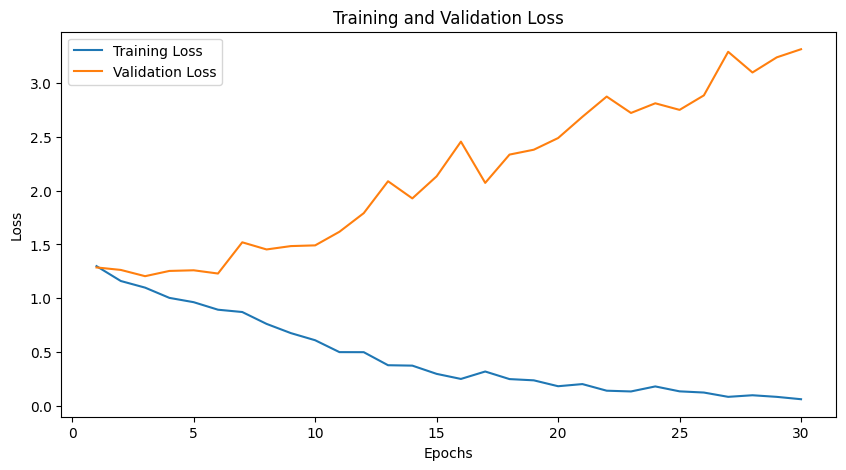

In [144]:
model_sentence_gru = GRUModel()
train(train_dataset_2, val_dataset_2, model_sentence_gru, epochs = 30, learning_rate=0.001)

100%|██████████| 54/54 [00:00<00:00, 340.55it/s]


Epoch [1/30], Train Loss: 1.2758, Train Accuracy: 35.12% , Val Loss: 1.4105, Val Accuracy: 24.68%


100%|██████████| 54/54 [00:00<00:00, 369.22it/s]


Epoch [2/30], Train Loss: 1.1958, Train Accuracy: 39.07% , Val Loss: 1.2746, Val Accuracy: 32.47%


100%|██████████| 54/54 [00:00<00:00, 384.91it/s]


Epoch [3/30], Train Loss: 1.1360, Train Accuracy: 42.09% , Val Loss: 1.2345, Val Accuracy: 41.56%


100%|██████████| 54/54 [00:00<00:00, 385.25it/s]


Epoch [4/30], Train Loss: 0.9895, Train Accuracy: 57.67% , Val Loss: 1.1081, Val Accuracy: 49.35%


100%|██████████| 54/54 [00:00<00:00, 393.72it/s]


Epoch [5/30], Train Loss: 0.7603, Train Accuracy: 71.16% , Val Loss: 0.9444, Val Accuracy: 59.74%


100%|██████████| 54/54 [00:00<00:00, 385.94it/s]


Epoch [6/30], Train Loss: 0.6164, Train Accuracy: 76.05% , Val Loss: 1.0565, Val Accuracy: 61.04%


100%|██████████| 54/54 [00:00<00:00, 370.76it/s]


Epoch [7/30], Train Loss: 0.4637, Train Accuracy: 83.26% , Val Loss: 0.9602, Val Accuracy: 59.74%


100%|██████████| 54/54 [00:00<00:00, 383.17it/s]


Epoch [8/30], Train Loss: 0.3807, Train Accuracy: 85.12% , Val Loss: 1.0032, Val Accuracy: 66.23%


100%|██████████| 54/54 [00:00<00:00, 400.97it/s]


Epoch [9/30], Train Loss: 0.2647, Train Accuracy: 90.70% , Val Loss: 1.0255, Val Accuracy: 68.83%


100%|██████████| 54/54 [00:00<00:00, 395.86it/s]


Epoch [10/30], Train Loss: 0.2276, Train Accuracy: 90.70% , Val Loss: 1.4504, Val Accuracy: 58.44%


100%|██████████| 54/54 [00:00<00:00, 391.37it/s]


Epoch [11/30], Train Loss: 0.2175, Train Accuracy: 91.40% , Val Loss: 1.1215, Val Accuracy: 68.83%


100%|██████████| 54/54 [00:00<00:00, 376.54it/s]


Epoch [12/30], Train Loss: 0.1509, Train Accuracy: 95.58% , Val Loss: 1.3061, Val Accuracy: 62.34%


100%|██████████| 54/54 [00:00<00:00, 376.06it/s]


Epoch [13/30], Train Loss: 0.1375, Train Accuracy: 95.81% , Val Loss: 1.1382, Val Accuracy: 67.53%


100%|██████████| 54/54 [00:00<00:00, 376.84it/s]


Epoch [14/30], Train Loss: 0.1066, Train Accuracy: 96.98% , Val Loss: 1.0463, Val Accuracy: 67.53%


100%|██████████| 54/54 [00:00<00:00, 381.90it/s]


Epoch [15/30], Train Loss: 0.1052, Train Accuracy: 96.74% , Val Loss: 1.1367, Val Accuracy: 71.43%


100%|██████████| 54/54 [00:00<00:00, 373.24it/s]


Epoch [16/30], Train Loss: 0.1049, Train Accuracy: 96.98% , Val Loss: 1.0999, Val Accuracy: 71.43%


100%|██████████| 54/54 [00:00<00:00, 396.27it/s]


Epoch [17/30], Train Loss: 0.1136, Train Accuracy: 94.88% , Val Loss: 1.2388, Val Accuracy: 62.34%


100%|██████████| 54/54 [00:00<00:00, 398.51it/s]


Epoch [18/30], Train Loss: 0.1049, Train Accuracy: 95.58% , Val Loss: 1.1851, Val Accuracy: 68.83%


100%|██████████| 54/54 [00:00<00:00, 405.32it/s]


Epoch [19/30], Train Loss: 0.1073, Train Accuracy: 95.35% , Val Loss: 1.2613, Val Accuracy: 71.43%


100%|██████████| 54/54 [00:00<00:00, 389.16it/s]


Epoch [20/30], Train Loss: 0.1507, Train Accuracy: 95.35% , Val Loss: 1.2798, Val Accuracy: 68.83%


100%|██████████| 54/54 [00:00<00:00, 381.01it/s]


Epoch [21/30], Train Loss: 0.0681, Train Accuracy: 97.91% , Val Loss: 1.4499, Val Accuracy: 63.64%


100%|██████████| 54/54 [00:00<00:00, 373.98it/s]


Epoch [22/30], Train Loss: 0.0416, Train Accuracy: 99.07% , Val Loss: 1.4997, Val Accuracy: 70.13%


100%|██████████| 54/54 [00:00<00:00, 382.59it/s]


Epoch [23/30], Train Loss: 0.1276, Train Accuracy: 94.88% , Val Loss: 1.3208, Val Accuracy: 72.73%


100%|██████████| 54/54 [00:00<00:00, 392.28it/s]


Epoch [24/30], Train Loss: 0.0975, Train Accuracy: 96.51% , Val Loss: 1.3613, Val Accuracy: 63.64%


100%|██████████| 54/54 [00:00<00:00, 395.39it/s]


Epoch [25/30], Train Loss: 0.1520, Train Accuracy: 95.12% , Val Loss: 1.3275, Val Accuracy: 62.34%


100%|██████████| 54/54 [00:00<00:00, 386.46it/s]


Epoch [26/30], Train Loss: 0.1564, Train Accuracy: 93.02% , Val Loss: 1.2633, Val Accuracy: 66.23%


100%|██████████| 54/54 [00:00<00:00, 374.49it/s]


Epoch [27/30], Train Loss: 0.1504, Train Accuracy: 94.19% , Val Loss: 1.4407, Val Accuracy: 71.43%


100%|██████████| 54/54 [00:00<00:00, 398.33it/s]


Epoch [28/30], Train Loss: 0.0586, Train Accuracy: 98.37% , Val Loss: 1.4157, Val Accuracy: 66.23%


100%|██████████| 54/54 [00:00<00:00, 398.67it/s]


Epoch [29/30], Train Loss: 0.0765, Train Accuracy: 97.91% , Val Loss: 1.5851, Val Accuracy: 66.23%


100%|██████████| 54/54 [00:00<00:00, 398.55it/s]


Epoch [30/30], Train Loss: 0.0213, Train Accuracy: 99.53% , Val Loss: 1.6770, Val Accuracy: 70.13%


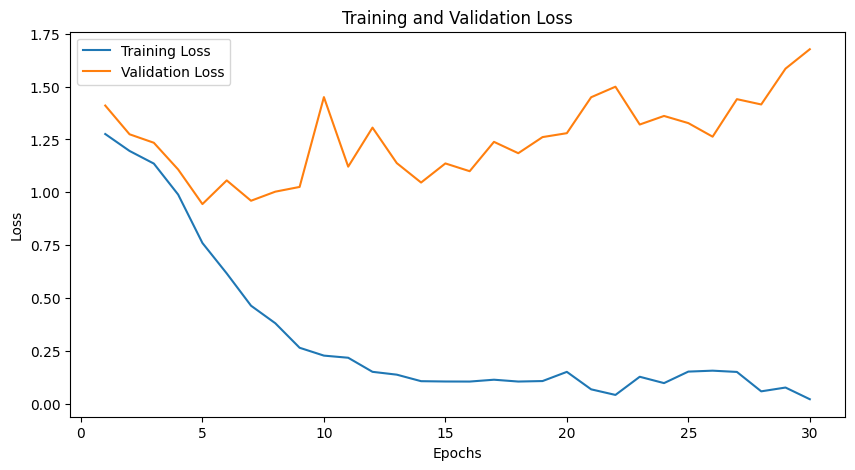

In [145]:
model_sentence_gru = RNNModel()
train(train_dataset_2, val_dataset_2, model_sentence_gru, epochs = 30, learning_rate=0.001)